In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import joblib 
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
vars = joblib.load('my_variables.pkl')

# Model Evaluation and Interpretability

__Model Interpretability using SHAP__

In [3]:
def plot_shap_summary(model, x_train, x_test):
    explainer = shap.Explainer(model, x_train)
    shap_values_train = explainer.shap_values(x_train)
    shap_values_test = explainer.shap_values(x_test)
    
    shap.summary_plot(shap_values_train, x_train, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Training Data")
    plt.show()
    
    shap.summary_plot(shap_values_test, x_test, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Test Data")
    plt.show()
    
    return shap_values_train, shap_values_test


__Top Features based on SHAP values__

In [4]:
def get_top_shap_values(shap_values, feature_names, top_n=5):
    abs_shap_values = np.abs(shap_values).mean(axis=0)
    top_feature_indices = np.argsort(abs_shap_values)[::-1][:top_n]
    top_features = [feature_names[i] for i in top_feature_indices]
    top_shap_values = abs_shap_values[top_feature_indices]
    return top_features, top_shap_values

__Model Implementation__

In [5]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="g", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix', color='orange', fontsize=16)
    plt.show()    

def model_classifier(model_type, x_train, x_test, y_train, y_test, display_results=True, display_shap=True, hyperparameters=None):
    if model_type == 'logistic_regression':
        model = LogisticRegression(**hyperparameters if hyperparameters else {})
    elif model_type == 'naive_bayes':
        model = GaussianNB()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(**hyperparameters if hyperparameters else {})
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**hyperparameters if hyperparameters else {})
    elif model_type == 'xgboost':
        model = XGBClassifier(**hyperparameters if hyperparameters else {})
    else:
        raise ValueError("Invalid model_type. Choose from: logistic_regression, naive_bayes, decision_tree, random_forest, knn, xgboost")

    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    
    if display_results:
        print("Classification Report for Training Set:\n")
        print(classification_report(y_train, train_predictions))

        print(f"Accuracy Score for Training Set: {train_accuracy}\n")

        print(f"ROC AUC Score for Training Set: {train_roc_auc}\n")

        print("Confusion Matrix for Training Set:\n")
        cm_train = confusion_matrix(y_train, train_predictions)
        plot_confusion_matrix(cm_train, labels=['Non-Fraud', 'Fraud'])
        
        
        print("\nClassification Report for Test Set:\n")
        print(classification_report(y_test, test_predictions))

        print(f"Accuracy Score for Test Set: {test_accuracy}\n")

        print(f"ROC AUC Score for Test Set: {test_roc_auc}\n")

        print("Confusion Matrix for Test Set:")
        cm_test = confusion_matrix(y_test, test_predictions)
        plot_confusion_matrix(cm_test, labels=['Non-Fraud', 'Fraud'])
        
    if display_shap:
        plot_shap_summary(model, x_train, x_test)
           
    return model

__Cross Validation__

In [6]:
def cross_val(model_type, x, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scoring = {'roc_auc': 'roc_auc', 
               'f1': 'f1',
               'accuracy': 'accuracy'}

    if model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'naive_bayes':
        model = GaussianNB()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier()
    elif model_type == 'random_forest':
        model = RandomForestClassifier()
    elif model_type == 'xgboost':
        model = XGBClassifier()
    else:
        raise ValueError("Invalid model_type. Choose from: logistic_regression, naive_bayes, decision_tree, random_forest, knn, xgboost")

    cv_results = cross_validate(model, x, y, cv=skf, scoring=scoring)

    for i, (roc_auc, f1, accuracy) in enumerate(zip(cv_results['test_roc_auc'], cv_results['test_f1'], cv_results['test_accuracy'])):
        print(f"Fold {i+1}: ROC AUC: {roc_auc}, F1 Score: {f1}, Accuracy: {accuracy}")

    mean_roc_auc = cv_results['test_roc_auc'].mean()
    mean_f1 = cv_results['test_f1'].mean()
    mean_accuracy = cv_results['test_accuracy'].mean()

    print("\nMean ROC AUC:", mean_roc_auc)
    print("Mean F1 Score:", mean_f1)
    print("Mean Accuracy:", mean_accuracy)

__Hyperparameter Tuning using GridSearchCV__

In [7]:
def LR_hyperparameter_tuning(x_train, x_test, y_train, y_test):
    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
    }
    
    lr = LogisticRegression()

    grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

    grid_search.fit(x_train, y_train) 

    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC AUC Score:", roc_auc)

    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

# LOGISTIC REGRESSION

__Model Performance After Feature Scaling__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.63      0.73       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9992143781957032

ROC AUC Score for Training Set: 0.9801025141868567

Confusion Matrix for Training Set:



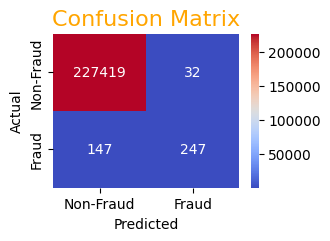


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.9762150006316539

Confusion Matrix for Test Set:


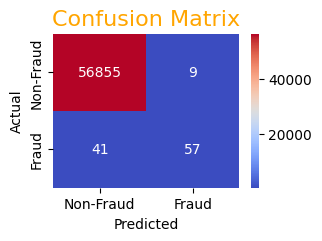

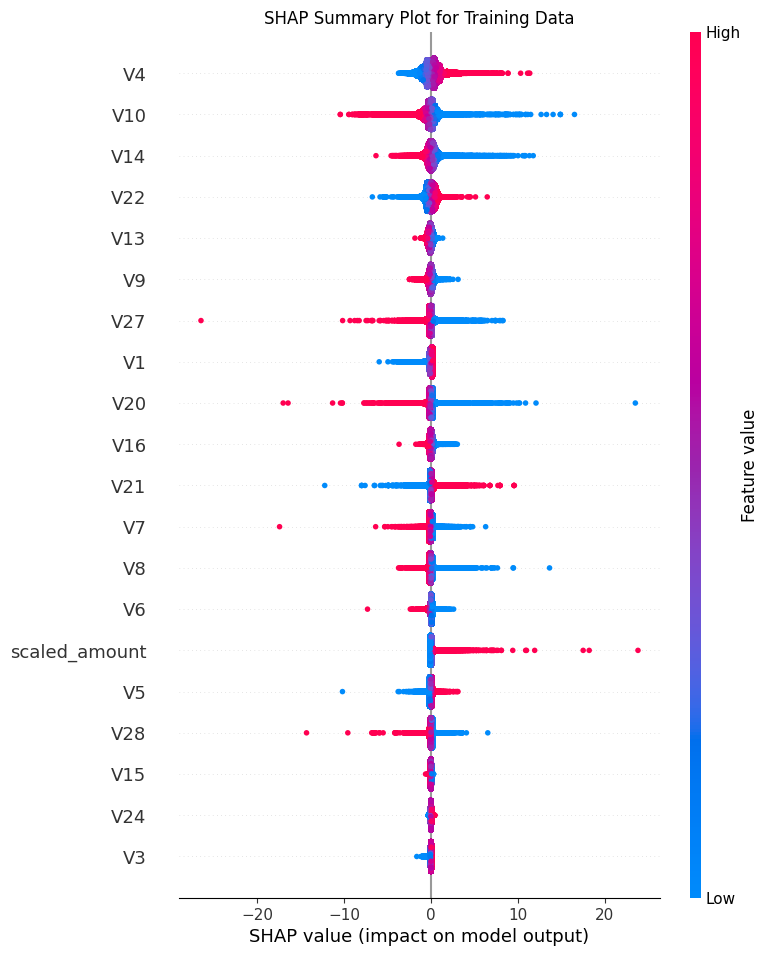

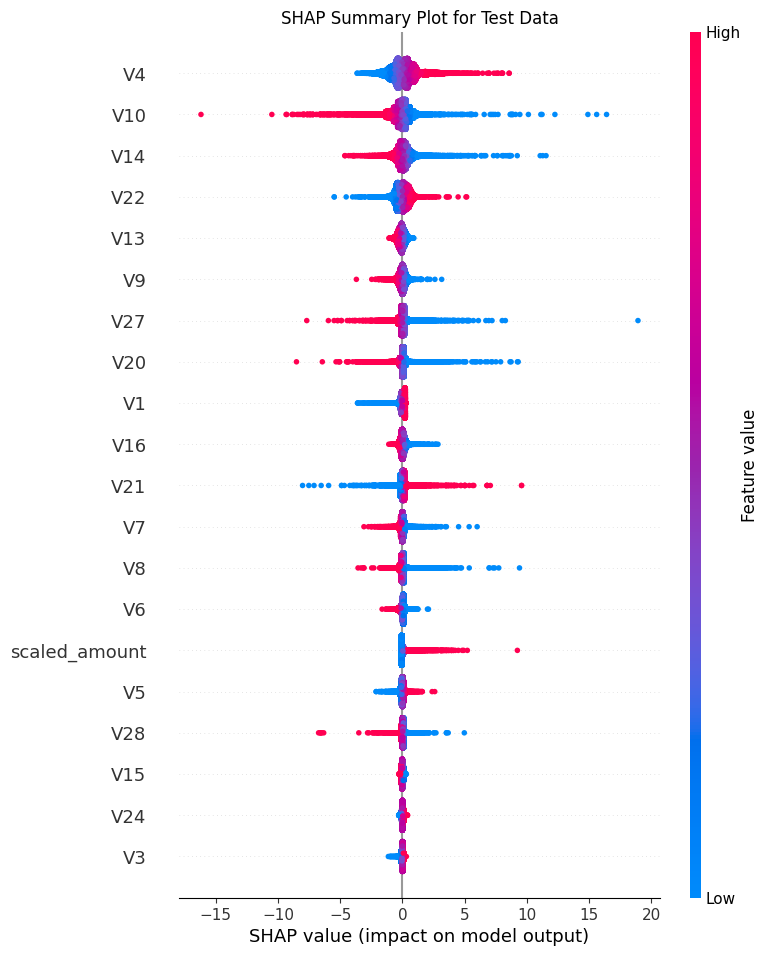

LogisticRegression()

In [39]:
model_classifier('logistic_regression', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'])

__Model Performance With Important Features extracted from RandomForest__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.61      0.72       394

    accuracy                           1.00    227845
   macro avg       0.94      0.80      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9991836555553117

ROC AUC Score for Training Set: 0.9756783672288473

Confusion Matrix for Training Set:



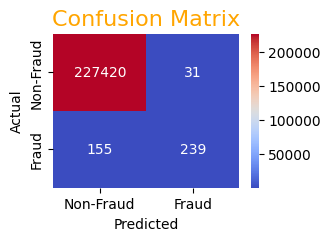


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9990871107053826

ROC AUC Score for Test Set: 0.9720276018398355

Confusion Matrix for Test Set:


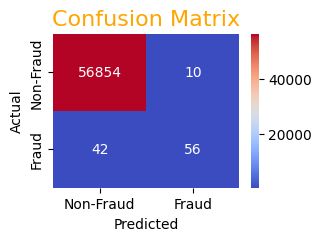

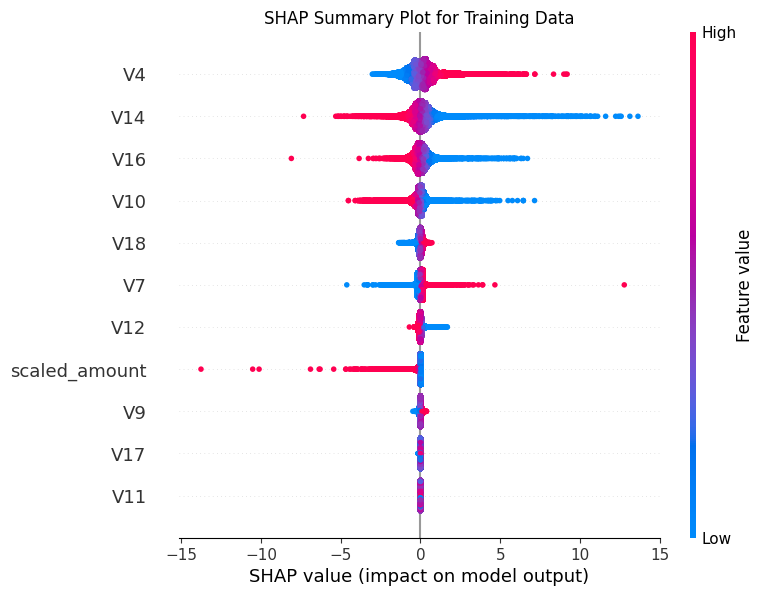

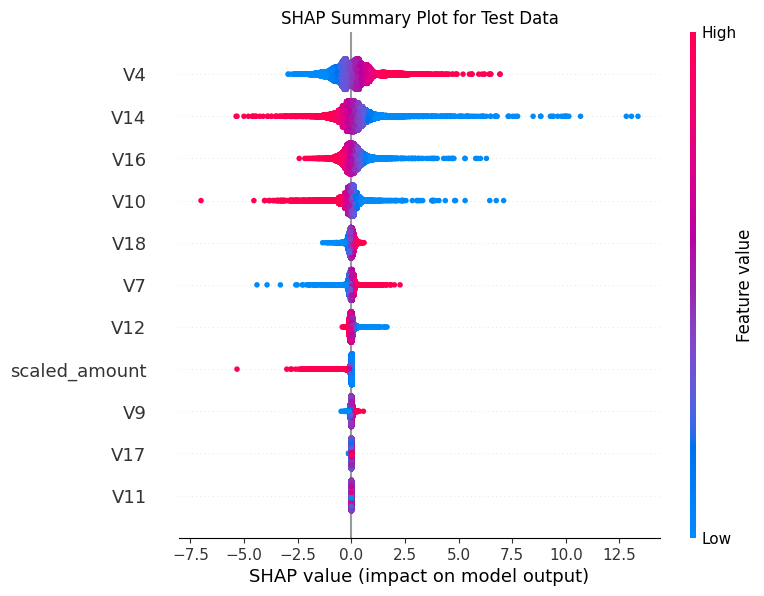

LogisticRegression()

In [10]:
model_classifier('logistic_regression', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'])

__Model Performance After Implementing LDA__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.87      0.55      0.67       394

    accuracy                           1.00    227845
   macro avg       0.94      0.77      0.84    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9990783207882552

ROC AUC Score for Training Set: 0.9814123852011902

Confusion Matrix for Training Set:



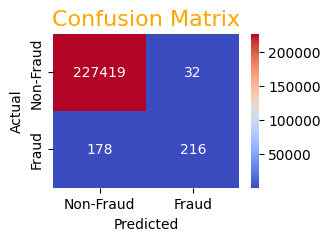


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9990871107053826

ROC AUC Score for Test Set: 0.9802270795769068

Confusion Matrix for Test Set:


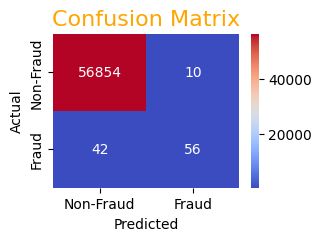

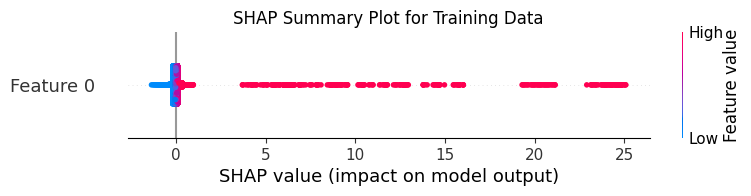

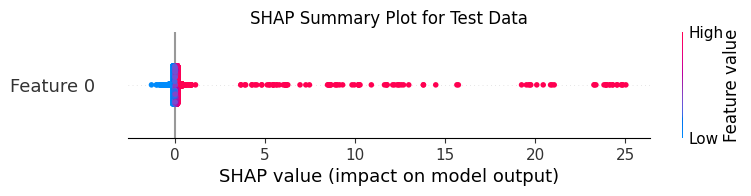

LogisticRegression()

In [11]:
model_classifier('logistic_regression', vars['x_train_lda'], vars['x_test_lda'], vars['y_train'], vars['y_test'])

__Model Performance With Cross Validation__

In [12]:
cross_val('logistic_regression', vars['x'], vars['y'])

Fold 1: ROC AUC: 0.97653477603533, F1 Score: 0.6871165644171778, Accuracy: 0.9991046662687406
Fold 2: ROC AUC: 0.9823302046012772, F1 Score: 0.7126436781609197, Accuracy: 0.9991222218320986
Fold 3: ROC AUC: 0.9788584234143862, F1 Score: 0.703030303030303, Accuracy: 0.9991397622934991
Fold 4: ROC AUC: 0.9650886645919822, F1 Score: 0.7590361445783133, Accuracy: 0.9992977651375503
Fold 5: ROC AUC: 0.9646192226428936, F1 Score: 0.7657142857142857, Accuracy: 0.999280209265989

Mean ROC AUC: 0.9734862582571738
Mean F1 Score: 0.7255081951801998
Mean Accuracy: 0.9991889249595756


__Model Performance After Implementing SMOTE__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95    227451
           1       0.97      0.92      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

Accuracy Score for Training Set: 0.9467115994214138

ROC AUC Score for Training Set: 0.9902744302045164

Confusion Matrix for Training Set:



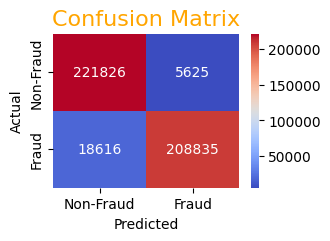


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Accuracy Score for Test Set: 0.9742459885537726

ROC AUC Score for Test Set: 0.9786380752357215

Confusion Matrix for Test Set:


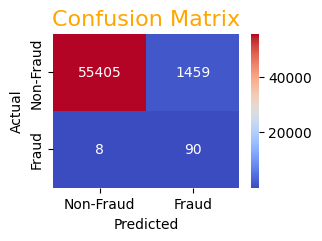

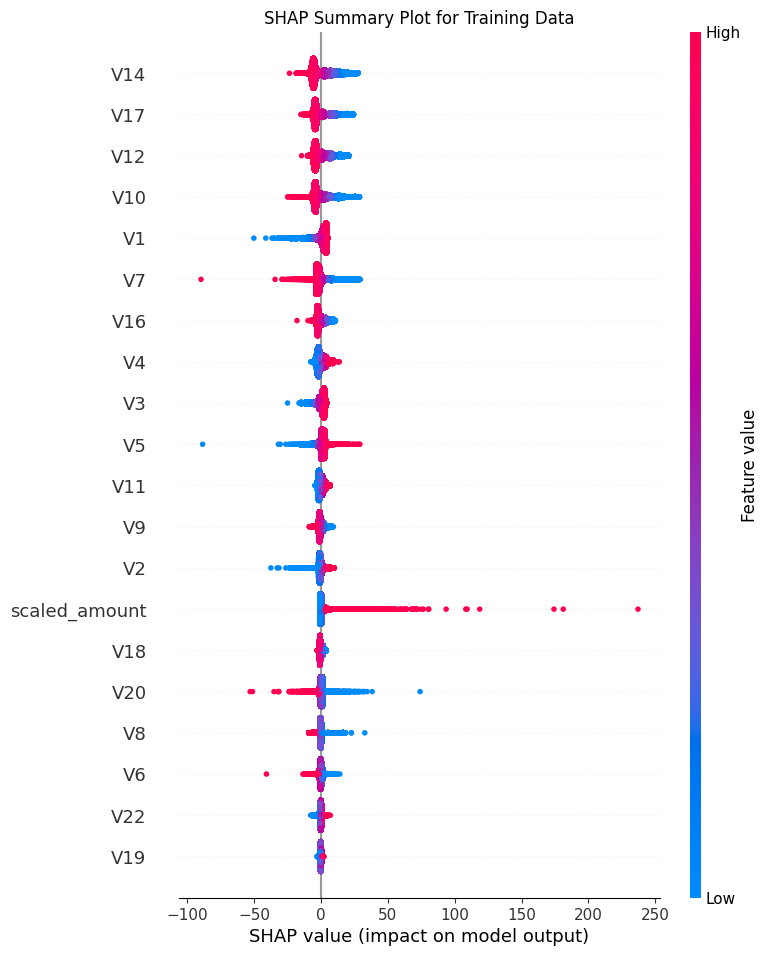

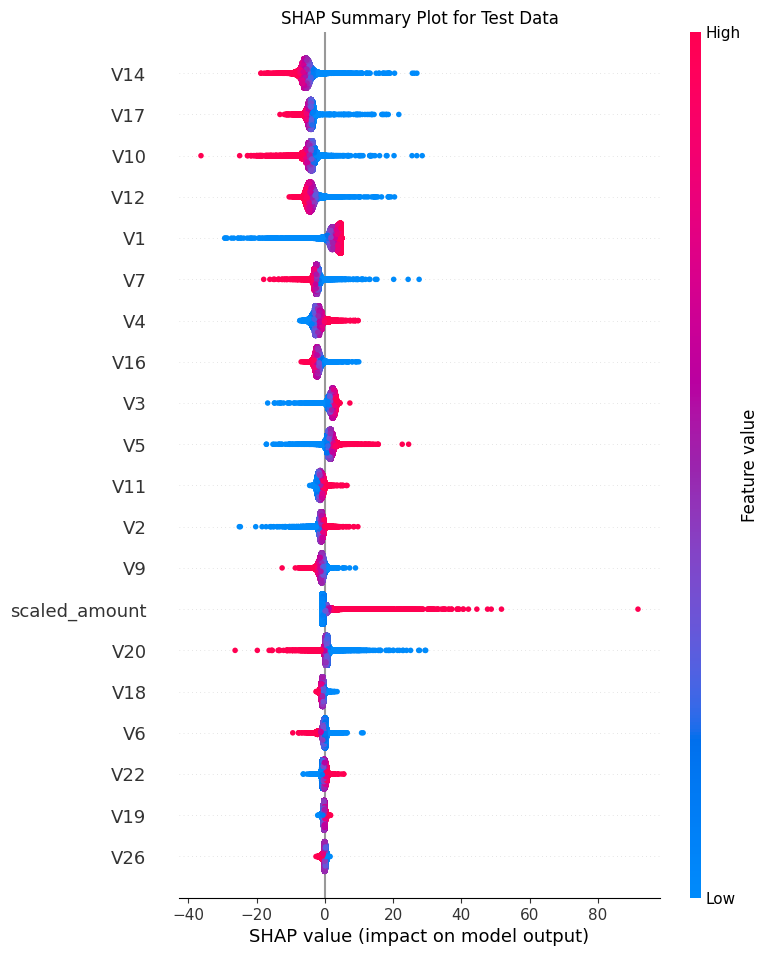

LogisticRegression()

In [13]:
model_classifier('logistic_regression', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'])

__Model Performance After Implementing ADASYN__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90    227451
           1       0.91      0.89      0.90    227397

    accuracy                           0.90    454848
   macro avg       0.90      0.90      0.90    454848
weighted avg       0.90      0.90      0.90    454848

Accuracy Score for Training Set: 0.9007074890952582

ROC AUC Score for Training Set: 0.9672561003010627

Confusion Matrix for Training Set:



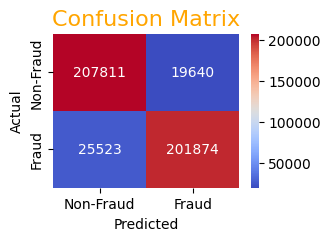


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.95      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962

Accuracy Score for Test Set: 0.9121870720831432

ROC AUC Score for Test Set: 0.9770376760017457

Confusion Matrix for Test Set:


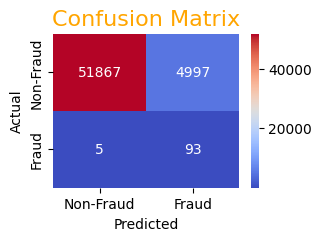

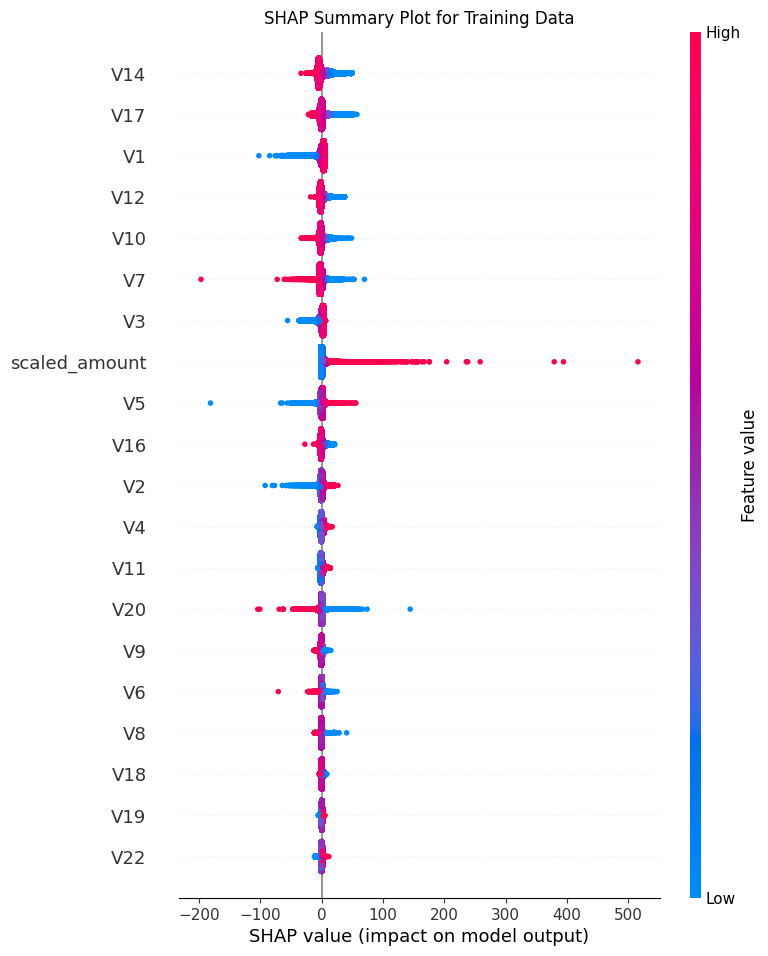

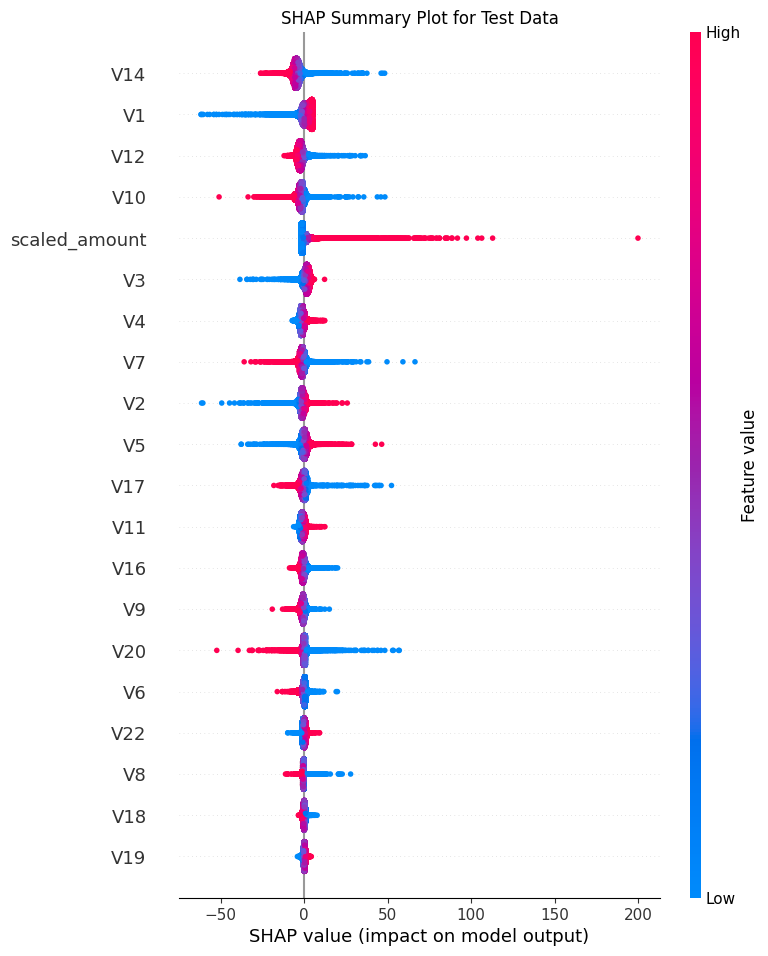

LogisticRegression()

In [14]:
model_classifier('logistic_regression', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'])

__Finding best Hyperparameter__

In [34]:
LR_hyperparameter_tuning(vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test']) 

Best Hyperparameters: {'C': 10, 'class_weight': None, 'penalty': 'l2'}
Test Accuracy: 0.9991222218320986
ROC AUC Score: 0.7907371903460314
F1 Score: 0.6951219512195121


__Model Performance with Scaled Features and best Hyperparameter__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.63      0.73       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9992143781957032

ROC AUC Score for Training Set: 0.9799345748524806

Confusion Matrix for Training Set:



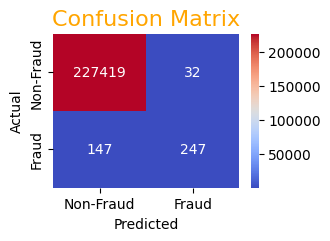


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.9760933354771284

Confusion Matrix for Test Set:


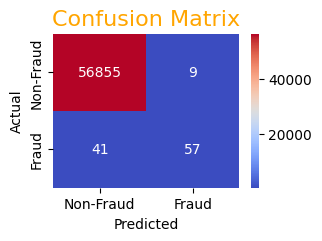

LogisticRegression(C=10)

In [35]:
hyperparameters = {'C': 10, 'class_weight': None, 'penalty': 'l2'}
model_classifier('logistic_regression', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

__Model Performance on Important Features from SHAP__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.61      0.72       394

    accuracy                           1.00    227845
   macro avg       0.94      0.80      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9991792666066843

ROC AUC Score for Training Set: 0.97470231051271

Confusion Matrix for Training Set:



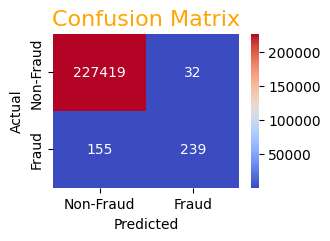


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.59      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.9750083981257106

Confusion Matrix for Test Set:


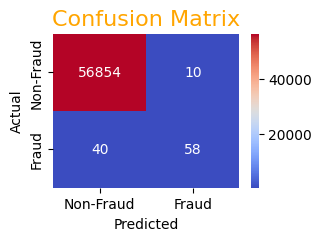

LogisticRegression()

In [71]:
top_features_train, top_shap_values_train = get_top_shap_values(shap_values_train, vars['x_train'].columns, top_n=10)
top_features_test, top_shap_values_train = get_top_shap_values(shap_values_test, vars['x_test'].columns, top_n=10)

# Get the intersection of column names between x_train and selected features
common_features = set(vars['x_train'].columns).intersection(top_features_train)

# Sort top_features_train and top_features_test based on the column order of x_train
top_features_train_sorted = [feature for feature in vars['x_train'].columns if feature in common_features]
top_features_test_sorted = [feature for feature in vars['x_train'].columns if feature in common_features]

# Use the sorted feature lists to select corresponding columns from x_train and x_test
x_train_selected = vars['x_train'][top_features_train_sorted]
x_test_selected = vars['x_test'][top_features_test_sorted]

model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance with SHAP's Important Features and best Hyperparameter__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.88      0.61      0.72       394

    accuracy                           1.00    227845
   macro avg       0.94      0.80      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9991792666066843

ROC AUC Score for Training Set: 0.9746411828267492

Confusion Matrix for Training Set:



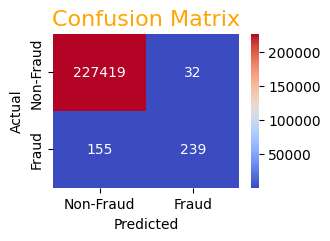


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.59      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.9750222155547643

Confusion Matrix for Test Set:


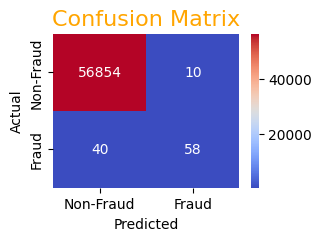

LogisticRegression(C=10)

In [73]:
hyperparameters = {'C': 10, 'class_weight': None, 'penalty': 'l2'}
model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

__Hyperparameter Tuning with SMOTE__

In [72]:
LR_hyperparameter_tuning(vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test']) 

Best Hyperparameters: {'C': 100, 'class_weight': None, 'penalty': 'l2'}
Test Accuracy: 0.9742459885537726
ROC AUC Score: 0.9463548186579077
F1 Score: 0.1092896174863388


Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95    227451
           1       0.97      0.92      0.95    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902

Accuracy Score for Training Set: 0.9467291856267943

ROC AUC Score for Training Set: 0.9902796466912025

Confusion Matrix for Training Set:



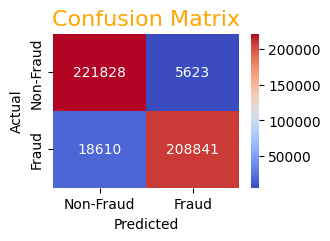


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Accuracy Score for Test Set: 0.9742459885537726

ROC AUC Score for Test Set: 0.9786326020982394

Confusion Matrix for Test Set:


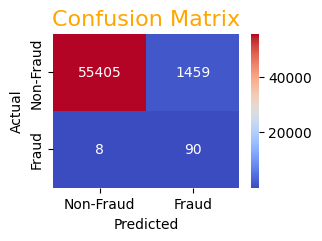

LogisticRegression(C=100)

In [74]:
hyperparameters = {'C': 100, 'class_weight':None, 'penalty': 'l2'}  
model_classifier('logistic_regression', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94    227451
           1       0.97      0.90      0.93    227451

    accuracy                           0.93    454902
   macro avg       0.94      0.93      0.93    454902
weighted avg       0.94      0.93      0.93    454902

Accuracy Score for Training Set: 0.9340803074068701

ROC AUC Score for Training Set: 0.9834299931212409

Confusion Matrix for Training Set:



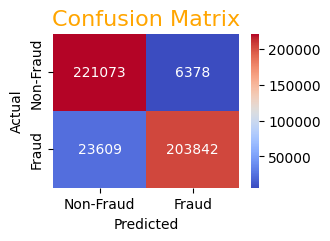


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Accuracy Score for Test Set: 0.9718233208103648

ROC AUC Score for Test Set: 0.9729806455502854

Confusion Matrix for Test Set:


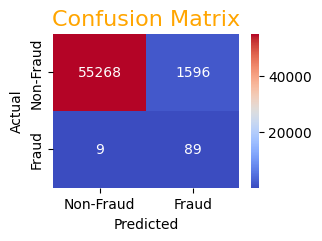

LogisticRegression()

In [75]:
top_features_train, top_shap_values_train = get_top_shap_values(shap_values_train, vars['x_train_smote'].columns, top_n=10)
top_features_test, top_shap_values_train = get_top_shap_values(shap_values_test, vars['x_test'].columns, top_n=10)

# Get the intersection of column names between x_train and selected features
common_features = set(vars['x_train_smote'].columns).intersection(top_features_train)

# Sort top_features_train and top_features_test based on the column order of x_train
top_features_train_sorted = [feature for feature in vars['x_train_smote'].columns if feature in common_features]
top_features_test_sorted = [feature for feature in vars['x_train_smote'].columns if feature in common_features]

# Use the sorted feature lists to select corresponding columns from x_train and x_test
x_train_selected = vars['x_train_smote'][top_features_train_sorted]
x_test_selected = vars['x_test'][top_features_test_sorted]

model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train_smote'], vars['y_test'], display_shap=False)

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.90      0.97      0.94    227451
           1       0.97      0.90      0.93    227451

    accuracy                           0.93    454902
   macro avg       0.94      0.93      0.93    454902
weighted avg       0.94      0.93      0.93    454902

Accuracy Score for Training Set: 0.9340825056825426

ROC AUC Score for Training Set: 0.9834299275356919

Confusion Matrix for Training Set:



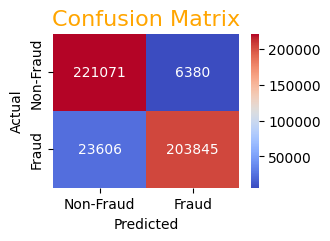


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.91      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Accuracy Score for Test Set: 0.9718233208103648

ROC AUC Score for Test Set: 0.972979568867502

Confusion Matrix for Test Set:


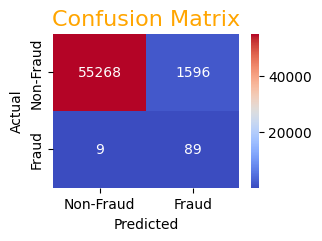

LogisticRegression(C=100)

In [76]:
hyperparameters = {'C': 100, 'class_weight': None, 'penalty': 'l2'}
model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train_smote'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

__Hyperparameter Tuning with ADASYN__

In [77]:
LR_hyperparameter_tuning(vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test']) 

Best Hyperparameters: {'C': 100, 'class_weight': None, 'penalty': 'l2'}
Test Accuracy: 0.9122397387732172
ROC AUC Score: 0.9305780063854467
F1 Score: 0.035872709739633565


Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90    227451
           1       0.91      0.89      0.90    227397

    accuracy                           0.90    454848
   macro avg       0.90      0.90      0.90    454848
weighted avg       0.90      0.90      0.90    454848

Accuracy Score for Training Set: 0.9007668495849163

ROC AUC Score for Training Set: 0.9672610651247998

Confusion Matrix for Training Set:



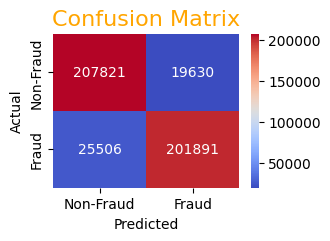


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     56864
           1       0.02      0.95      0.04        98

    accuracy                           0.91     56962
   macro avg       0.51      0.93      0.49     56962
weighted avg       1.00      0.91      0.95     56962

Accuracy Score for Test Set: 0.9122397387732172

ROC AUC Score for Test Set: 0.9770501475773203

Confusion Matrix for Test Set:


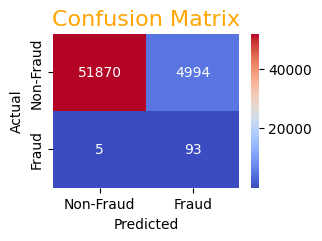

LogisticRegression(C=100)

In [78]:
hyperparameters = {'C': 100, 'class_weight':None, 'penalty': 'l2'}  
model_classifier('logistic_regression', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87    227451
           1       0.88      0.85      0.86    227397

    accuracy                           0.87    454848
   macro avg       0.87      0.87      0.87    454848
weighted avg       0.87      0.87      0.87    454848

Accuracy Score for Training Set: 0.8670149148726608

ROC AUC Score for Training Set: 0.9393786359267986

Confusion Matrix for Training Set:



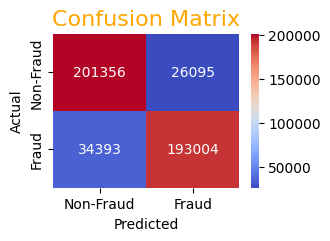


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.94      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.88      0.94     56962

Accuracy Score for Test Set: 0.8845897264843229

ROC AUC Score for Test Set: 0.9732227197294224

Confusion Matrix for Test Set:


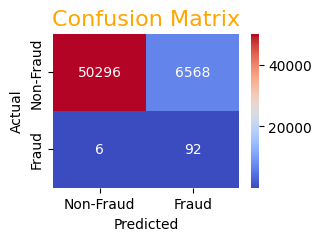

LogisticRegression()

In [79]:
top_features_train, top_shap_values_train = get_top_shap_values(shap_values_train, vars['x_train_adasyn'].columns, top_n=10)
top_features_test, top_shap_values_train = get_top_shap_values(shap_values_test, vars['x_test'].columns, top_n=10)

# Get the intersection of column names between x_train and selected features
common_features = set(vars['x_train_adasyn'].columns).intersection(top_features_train)

# Sort top_features_train and top_features_test based on the column order of x_train
top_features_train_sorted = [feature for feature in vars['x_train_adasyn'].columns if feature in common_features]
top_features_test_sorted = [feature for feature in vars['x_train_adasyn'].columns if feature in common_features]

# Use the sorted feature lists to select corresponding columns from x_train and x_test
x_train_selected = vars['x_train_adasyn'][top_features_train_sorted]
x_test_selected = vars['x_test'][top_features_test_sorted]

model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train_adasyn'], vars['y_test'], display_shap=False)

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87    227451
           1       0.88      0.85      0.86    227397

    accuracy                           0.87    454848
   macro avg       0.87      0.87      0.87    454848
weighted avg       0.87      0.87      0.87    454848

Accuracy Score for Training Set: 0.8670171134093148

ROC AUC Score for Training Set: 0.9393787444693003

Confusion Matrix for Training Set:



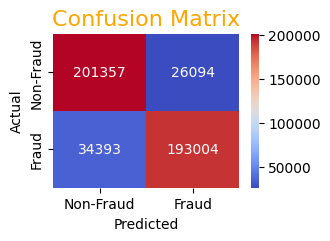


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     56864
           1       0.01      0.94      0.03        98

    accuracy                           0.88     56962
   macro avg       0.51      0.91      0.48     56962
weighted avg       1.00      0.88      0.94     56962

Accuracy Score for Test Set: 0.8845897264843229

ROC AUC Score for Test Set: 0.9732223608351612

Confusion Matrix for Test Set:


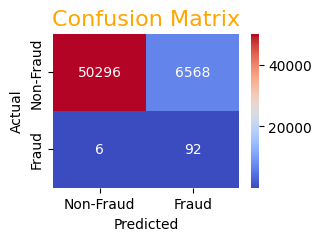

LogisticRegression(C=100)

In [80]:
hyperparameters = {'C': 100, 'class_weight': None, 'penalty': 'l2'}
model_classifier('logistic_regression', x_train_selected, x_test_selected, vars['y_train_adasyn'], vars['y_test'], display_shap=False, hyperparameters=hyperparameters)

# NAIVE BAYES

__Model Performance with Scaled Features__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    227451
           1       0.06      0.83      0.12       394

    accuracy                           0.98    227845
   macro avg       0.53      0.91      0.55    227845
weighted avg       1.00      0.98      0.99    227845

Accuracy Score for Training Set: 0.978480984880072

ROC AUC Score for Training Set: 0.9596201085046555

Confusion Matrix for Training Set:



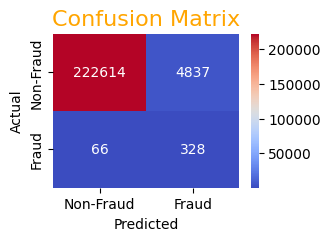


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.82      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.90      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy Score for Test Set: 0.9776342122818721

ROC AUC Score for Test Set: 0.9671032136827719

Confusion Matrix for Test Set:


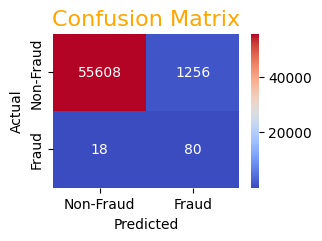

GaussianNB()

In [83]:
model_classifier('naive_bayes', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance with Important Features extracted from RandomForest__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    227451
           1       0.15      0.85      0.26       394

    accuracy                           0.99    227845
   macro avg       0.58      0.92      0.63    227845
weighted avg       1.00      0.99      0.99    227845

Accuracy Score for Training Set: 0.9915512738923391

ROC AUC Score for Training Set: 0.9678884314615697

Confusion Matrix for Training Set:



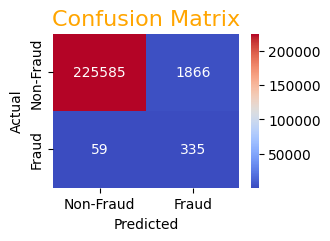


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.15      0.86      0.25        98

    accuracy                           0.99     56962
   macro avg       0.57      0.92      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Accuracy Score for Test Set: 0.9913451072644921

ROC AUC Score for Test Set: 0.9547862318112389

Confusion Matrix for Test Set:


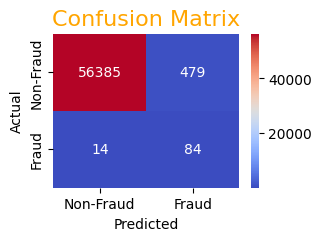

GaussianNB()

In [85]:
model_classifier('naive_bayes', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance with Cross Validation__

In [87]:
cross_val('naive_bayes', vars['x'], vars['y'])

Fold 1: ROC AUC: 0.9531205340782747, F1 Score: 0.12121212121212122, Accuracy: 0.9791264351673045
Fold 2: ROC AUC: 0.96663316420452, F1 Score: 0.11519777931991672, Accuracy: 0.977616656718514
Fold 3: ROC AUC: 0.9696885137819613, F1 Score: 0.1189111747851003, Accuracy: 0.9784062779796703
Fold 4: ROC AUC: 0.9558927346680367, F1 Score: 0.10379241516966069, Accuracy: 0.9763522410070048
Fold 5: ROC AUC: 0.9570977433408691, F1 Score: 0.11573747353563867, Accuracy: 0.9780024929337617

Mean ROC AUC: 0.9604865380147324
Mean F1 Score: 0.1149701928044875
Mean Accuracy: 0.977900820761251


__Model Performance after implementing SMOTE__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.87      0.98      0.92    227451
           1       0.97      0.85      0.91    227451

    accuracy                           0.91    454902
   macro avg       0.92      0.91      0.91    454902
weighted avg       0.92      0.91      0.91    454902

Accuracy Score for Training Set: 0.9131637143824384

ROC AUC Score for Training Set: 0.9496841016854107

Confusion Matrix for Training Set:



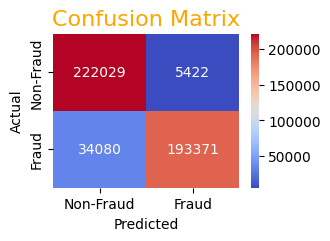


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962

Accuracy Score for Test Set: 0.975685544749131

ROC AUC Score for Test Set: 0.9661137422048167

Confusion Matrix for Test Set:


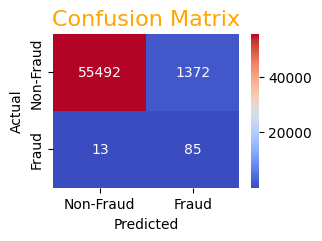

GaussianNB()

In [89]:
model_classifier('naive_bayes', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'], display_shap=False)

__Model Performance after Implementing ADASYN__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       0.65      0.96      0.78    227451
           1       0.93      0.49      0.64    227397

    accuracy                           0.73    454848
   macro avg       0.79      0.73      0.71    454848
weighted avg       0.79      0.73      0.71    454848

Accuracy Score for Training Set: 0.7270692626987477

ROC AUC Score for Training Set: 0.8508661058349192

Confusion Matrix for Training Set:



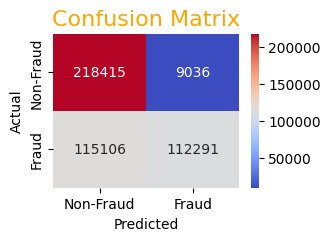


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.90      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.93      0.53     56962
weighted avg       1.00      0.96      0.98     56962

Accuracy Score for Test Set: 0.9600084266704119

ROC AUC Score for Test Set: 0.9686014177758893

Confusion Matrix for Test Set:


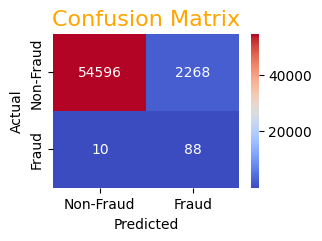

GaussianNB()

In [90]:
model_classifier('naive_bayes', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'], display_shap=False)

# DECISION TREE

__Model Performance with Scaled Features__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



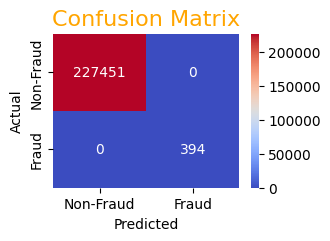


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.79      0.75        98

    accuracy                           1.00     56962
   macro avg       0.86      0.89      0.88     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.8926021484846047

Confusion Matrix for Test Set:


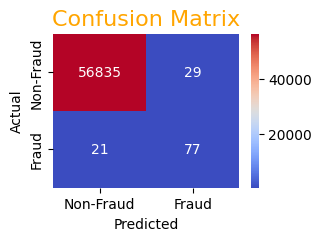

 95%|=================== | 431200/455690 [00:17<00:00]       

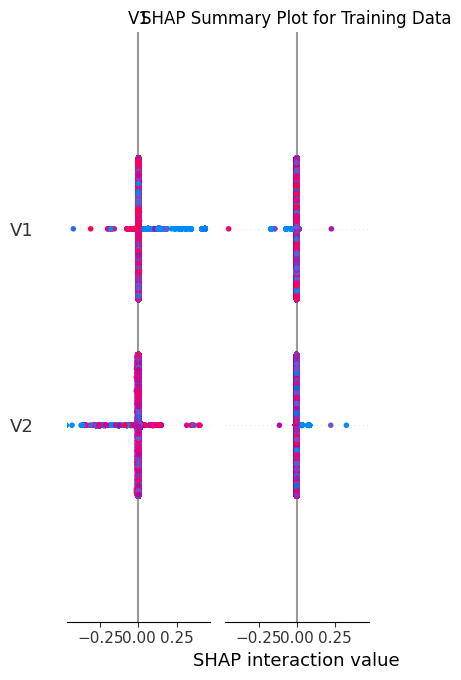

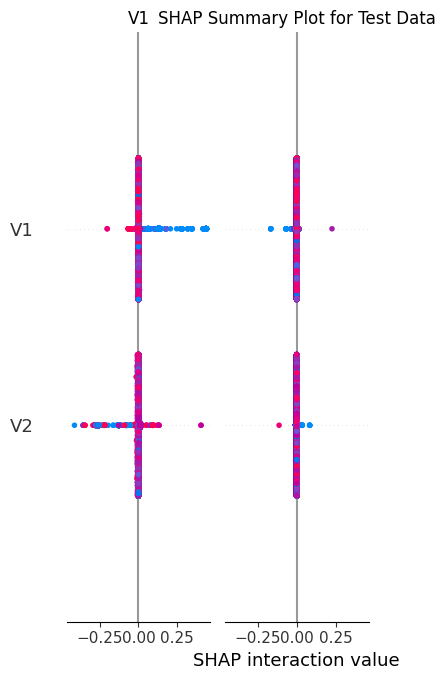

DecisionTreeClassifier()

In [91]:
model_classifier('decision_tree', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'])

__Model Performance with Important Features extracted from RandomForest__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



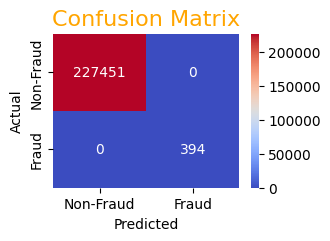


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.76      0.74        98

    accuracy                           1.00     56962
   macro avg       0.86      0.88      0.87     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9990871107053826

ROC AUC Score for Test Set: 0.8773048189450231

Confusion Matrix for Test Set:


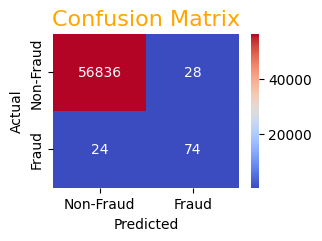

 97%|=================== | 442591/455690 [00:16<00:00]       

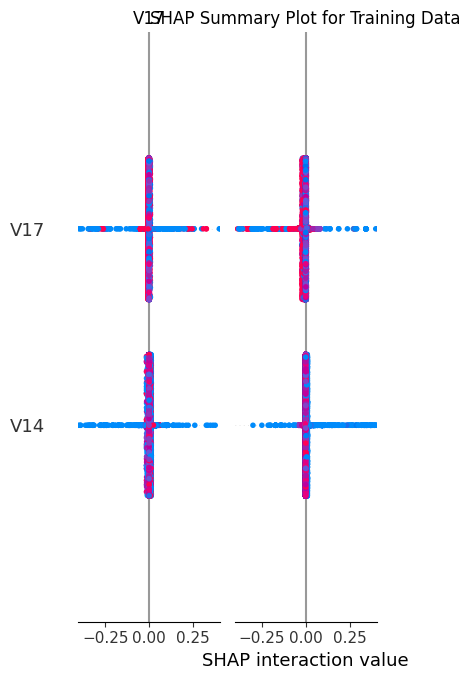

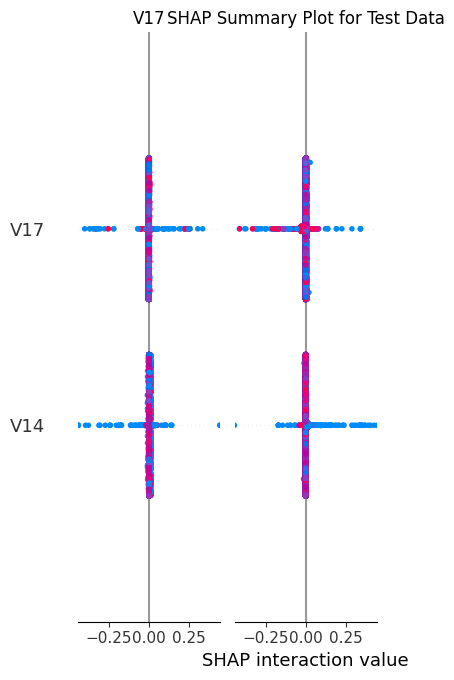

DecisionTreeClassifier()

In [92]:
model_classifier('decision_tree', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'])

__Model Performance after implementing SMOTE__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



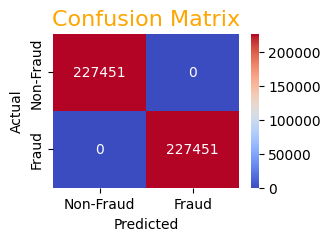


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.36      0.72      0.48        98

    accuracy                           1.00     56962
   macro avg       0.68      0.86      0.74     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9973315543695798

ROC AUC Score for Test Set: 0.861145784284451

Confusion Matrix for Test Set:


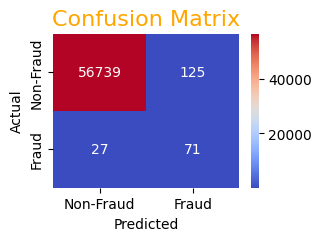

 95%|=================== | 108110/113924 [00:17<00:00]       

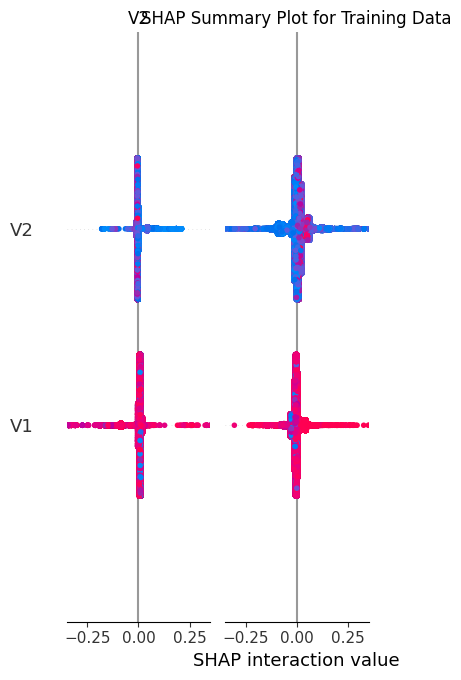

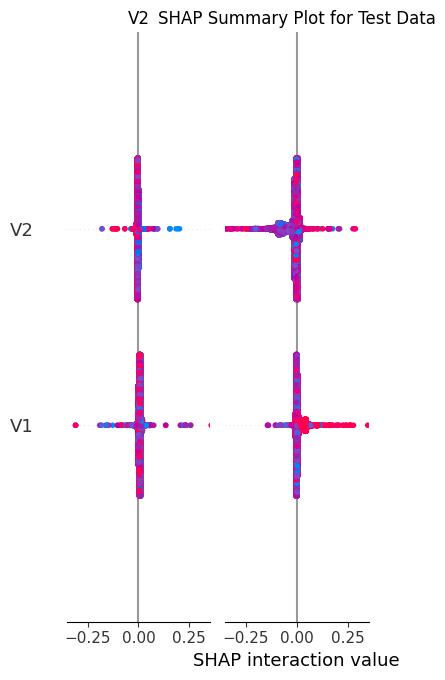

DecisionTreeClassifier()

In [122]:
model_classifier('decision_tree', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'])

__Model Performance after implementing ADASYN__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227397

    accuracy                           1.00    454848
   macro avg       1.00      1.00      1.00    454848
weighted avg       1.00      1.00      1.00    454848

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



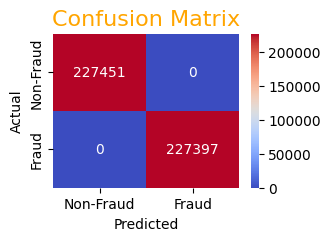


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.43      0.74      0.54        98

    accuracy                           1.00     56962
   macro avg       0.71      0.87      0.77     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9978406657069625

ROC AUC Score for Test Set: 0.8715872744708464

Confusion Matrix for Test Set:


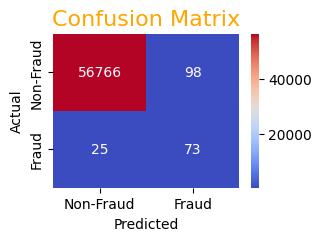

 99%|===================| 113306/113924 [00:21<00:00]        

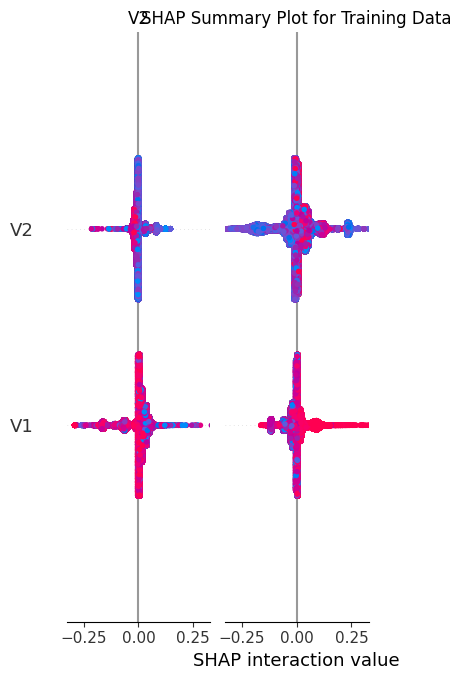

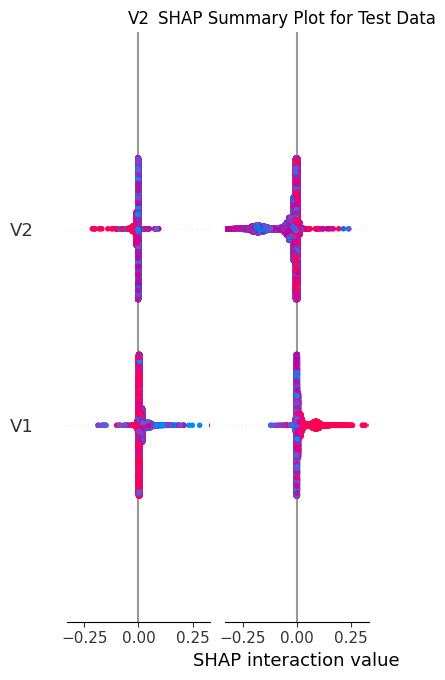

DecisionTreeClassifier()

In [124]:
model_classifier('decision_tree', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'])

__Model Performance with important features from SHAP__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



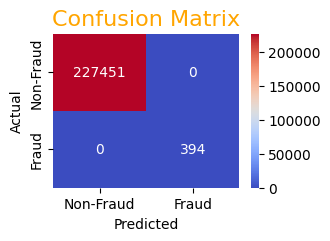


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.78      0.80        98

    accuracy                           1.00     56962
   macro avg       0.91      0.89      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9993153330290369

ROC AUC Score for Test Set: 0.8876056225810527

Confusion Matrix for Test Set:


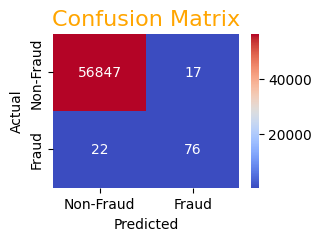

DecisionTreeClassifier()

In [125]:
top_features_train, top_shap_values_train = get_top_shap_values(shap_values_train, vars['x_train'].columns, top_n=10)
top_features_test, top_shap_values_train = get_top_shap_values(shap_values_test, vars['x_test'].columns, top_n=10)

# Get the intersection of column names between x_train and selected features
common_features = set(vars['x_train'].columns).intersection(top_features_train)

# Sort top_features_train and top_features_test based on the column order of x_train
top_features_train_sorted = [feature for feature in vars['x_train'].columns if feature in common_features]
top_features_test_sorted = [feature for feature in vars['x_train'].columns if feature in common_features]

# Use the sorted feature lists to select corresponding columns from x_train and x_test
x_train_selected = vars['x_train'][top_features_train_sorted]
x_test_selected = vars['x_test'][top_features_test_sorted]

model_classifier('decision_tree', x_train_selected, x_test_selected, vars['y_train'], vars['y_test'], display_shap=False)

# RANDOM FOREST

__Model Performance with Scaled features__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



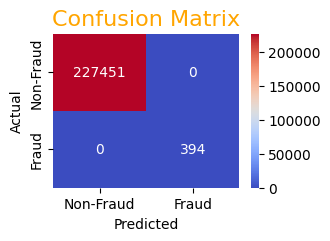


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9995611109160493

ROC AUC Score for Test Set: 0.942477504507712

Confusion Matrix for Test Set:


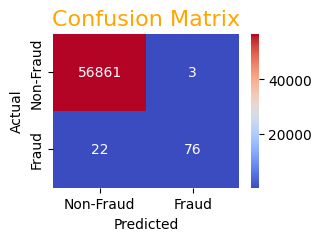

RandomForestClassifier()

In [8]:
model_classifier('random_forest', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance with important features extracted from RandomForest__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



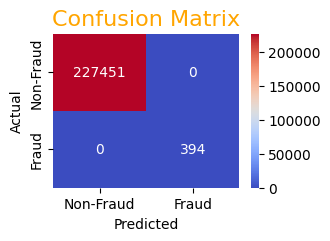


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.79      0.87        98

    accuracy                           1.00     56962
   macro avg       0.98      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9995786664794073

ROC AUC Score for Test Set: 0.9528164406589873

Confusion Matrix for Test Set:


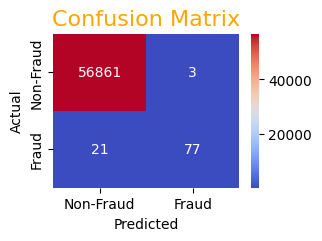

RandomForestClassifier()

In [9]:
model_classifier('random_forest', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance after implementing SMOTE__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



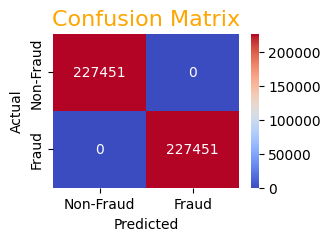


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.85      0.88        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9996137776061234

ROC AUC Score for Test Set: 0.979312258105268

Confusion Matrix for Test Set:


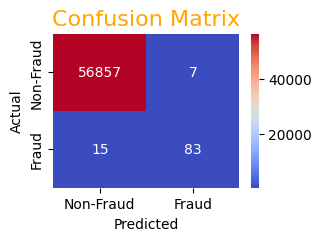

RandomForestClassifier()

In [10]:
model_classifier('random_forest', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'], display_shap=False)

__Model Performance after implementing ADASYN__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227397

    accuracy                           1.00    454848
   macro avg       1.00      1.00      1.00    454848
weighted avg       1.00      1.00      1.00    454848

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



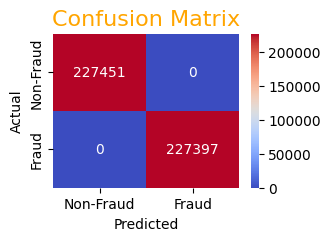


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.91      0.84      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.92      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9995786664794073

ROC AUC Score for Test Set: 0.983384362115696

Confusion Matrix for Test Set:


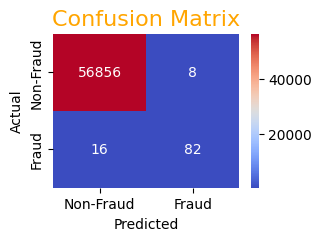

RandomForestClassifier()

In [11]:
model_classifier('random_forest', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'], display_shap=False)

# XGBOOST

__Model Performance with Scaled features__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00       394

    accuracy                           1.00    227845
   macro avg       1.00      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 1.0

ROC AUC Score for Training Set: 1.0

Confusion Matrix for Training Set:



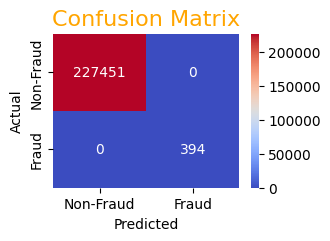


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.80      0.88        98

    accuracy                           1.00     56962
   macro avg       0.99      0.90      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9996137776061234

ROC AUC Score for Test Set: 0.9844539567374502

Confusion Matrix for Test Set:


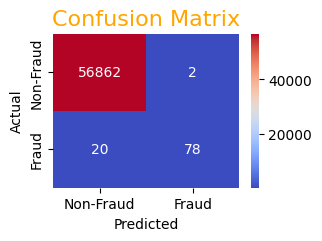

100%|===================| 56961/56962 [02:01<00:00]          

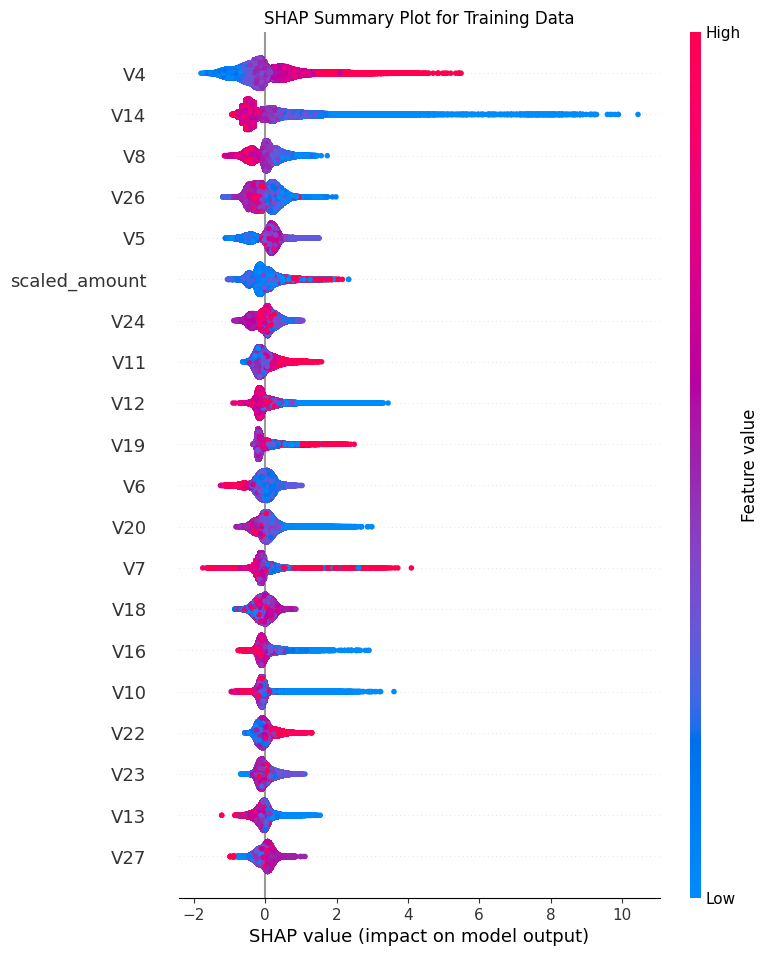

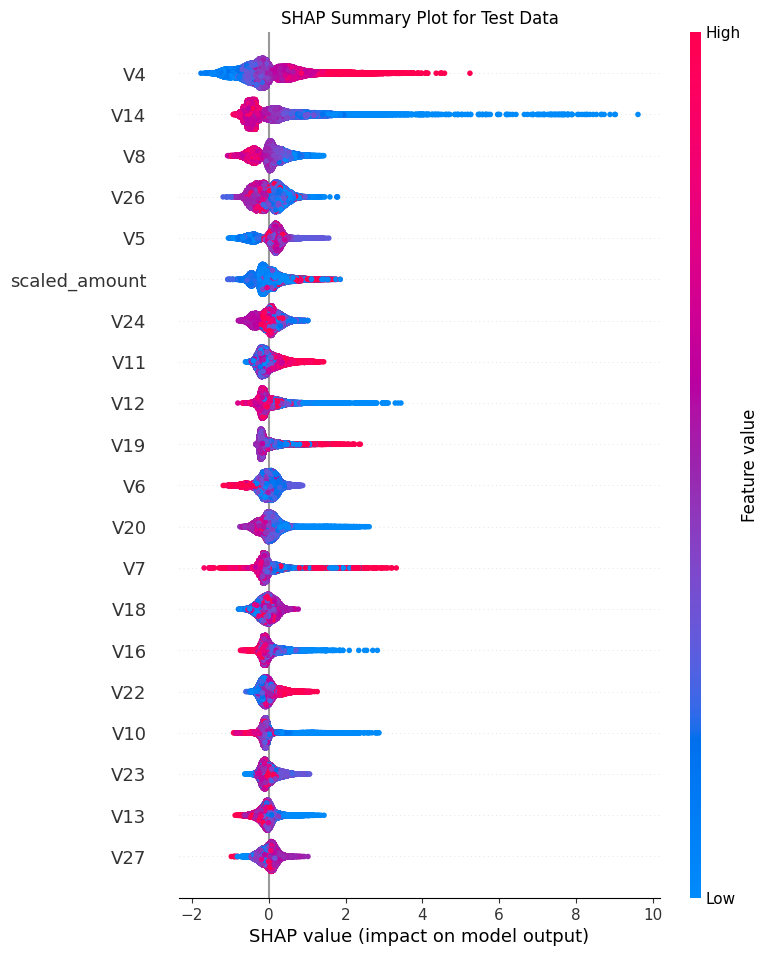

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [15]:
model_classifier('xgboost', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'])

__Model Performance with important features__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.99      1.00      0.99       394

    accuracy                           1.00    227845
   macro avg       0.99      1.00      1.00    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9999780552568632

ROC AUC Score for Training Set: 0.9999974613821547

Confusion Matrix for Training Set:



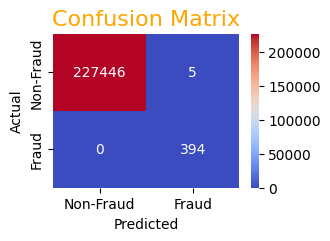


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.97      0.78      0.86        98

    accuracy                           1.00     56962
   macro avg       0.99      0.89      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9995786664794073

ROC AUC Score for Test Set: 0.9753222511570752

Confusion Matrix for Test Set:


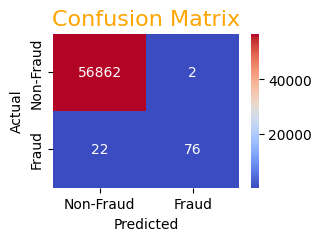

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
model_classifier('xgboost', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'], display_shap=False)

__Model Performance after implementing SMOTE__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902

Accuracy Score for Training Set: 0.9999912068973098

ROC AUC Score for Training Set: 0.999999999884022

Confusion Matrix for Training Set:



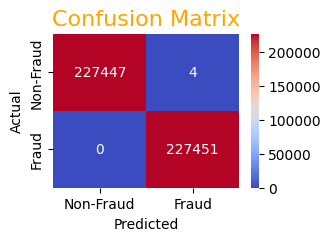


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.88      0.79        98

    accuracy                           1.00     56962
   macro avg       0.86      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9992099996488887

ROC AUC Score for Test Set: 0.9891533181927807

Confusion Matrix for Test Set:


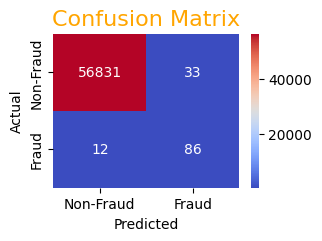

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
model_classifier('xgboost', vars['x_train_smote'], vars['x_test'], vars['y_train_smote'], vars['y_test'], display_shap=False)

__Model Performance after implementing ADASYN__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227397

    accuracy                           1.00    454848
   macro avg       1.00      1.00      1.00    454848
weighted avg       1.00      1.00      1.00    454848

Accuracy Score for Training Set: 0.9999824117067679

ROC AUC Score for Training Set: 0.9999999999806657

Confusion Matrix for Training Set:



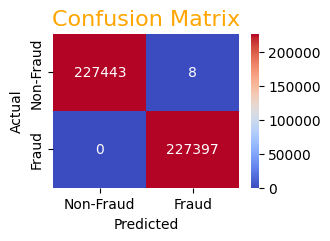


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.70      0.88      0.78        98

    accuracy                           1.00     56962
   macro avg       0.85      0.94      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991573329588147

ROC AUC Score for Test Set: 0.9803636388432695

Confusion Matrix for Test Set:


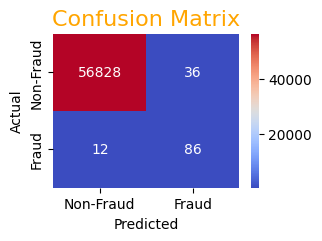

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
model_classifier('xgboost', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'], display_shap=False)

# SAVING THE MODEL'S PREDICTION

In [11]:
hyperparameters = {'C': 100, 'class_weight':None, 'penalty': 'l2'}  

test_predictions = model_classifier('logistic_regression', vars['x_train_adasyn'], vars['x_test'], vars['y_train_adasyn'], vars['y_test'], display_results=False, display_shap=False, hyperparameters=hyperparameters)

joblib.dump(test_predictions, 'test_predictions.pkl')

['test_predictions.pkl']